In [70]:
import numpy as np
import keras
from keras import layers
from keras import metrics
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps 
import os
from os import listdir
import random

In [71]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)
# get the path/directory
image_list=[]
label_list=[]
folder_dir = "bmpProcessedSeuil"
for images in os.listdir(folder_dir):
    # check if the image ends with png
    if (images.endswith(".bmp")):
        temp=Image.open(folder_dir+"/"+images)
        temp=temp.rotate(180)
        temp=ImageOps.grayscale(temp) 
        image_list.append(temp)
        label_list.append(images.split('_')[0])
        #temp.show()

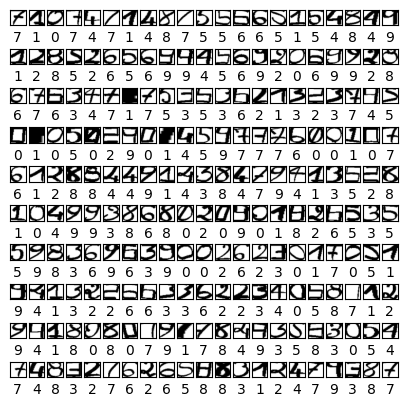

In [72]:
plt.figure(figsize=(5,5))
for i in range(210):
    plt.subplot(10,21,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image_list[i], cmap=plt.cm.binary)
    plt.xlabel(label_list[i])
plt.show()

Separation train set et test set + passage en numpy

In [73]:
train_set=[]
train_label=[]
test_set=[]
test_label=[]
r = list(range (len(image_list)))
random.shuffle(r)
for i in r:
    if label_list[i] in test_label : #deja une image dans le test avec le meme label
        train_set.append(image_list[i])
        train_label.append(label_list[i])
    else :
        test_set.append(image_list[i])
        test_label.append(label_list[i])

#convert to numpy arrays
train_set=np.asarray(train_set)
train_label=np.array(train_label)
test_set=np.asarray(test_set)
test_label=np.array(test_label)
print(train_set[0].shape)
train_set=np.expand_dims(train_set, -1)
test_set=np.expand_dims(test_set, -1)
print(train_set[0].shape)

(28, 28)
(28, 28, 1)


Preprocess data

In [74]:
# train_set = train_set / 255.0
# test_set = test_set / 255.0
x_train = train_set.astype("float32") / 255
x_test = test_set.astype("float32") / 255

y_train = keras.utils.to_categorical(train_label, num_classes)
y_test = keras.utils.to_categorical(test_label, num_classes)

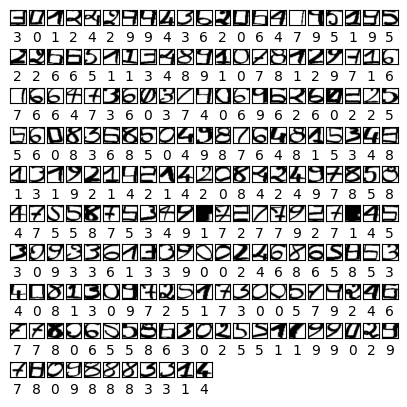

In [75]:
plt.figure(figsize=(5,5))
for i in range(200):
    plt.subplot(10,21,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_set[i], cmap=plt.cm.binary)
    plt.xlabel(train_label[i])
plt.show()

Create model

1/1 [==============================] - 0s 46ms/step - loss: 0.0143 - accuracy: 0.9000
Test loss model_base: 0.014260934665799141 accuracy 0.8999999761581421
Saved trained model at results/keras_mnist_base.h5 


/home/rocher/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


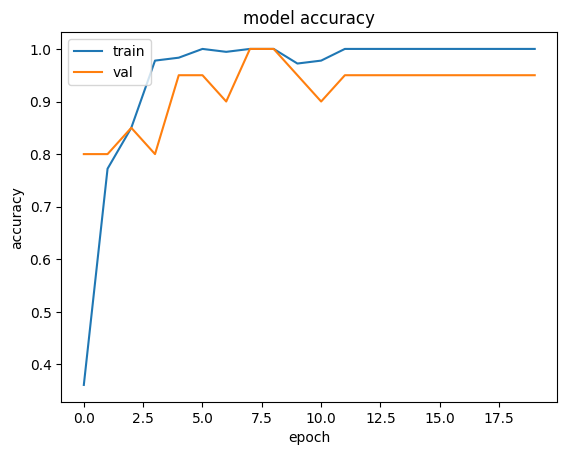

In [76]:
model_base = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
model_base.compile(loss="mse", optimizer="adam", metrics=["accuracy"])
history =model_base.fit(x_train, y_train, batch_size=1, epochs=20, validation_split=0.1,verbose=0,use_multiprocessing=False)
score = model_base.evaluate(x_test, y_test, verbose=1,use_multiprocessing=False)
print("Test loss model_base:", score[0],"accuracy",score[1])
# saving the model
save_dir = "results/"
model_name = 'keras_mnist_base.h5'
model_path = os.path.join(save_dir, model_name)
model_base.save(model_path)
print('Saved trained model at %s ' % model_path)
# plotting the metrics
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Evaluate model

1/1 [==============================] - 0s 32ms/step

98  classified correctly
2  classified incorrectly


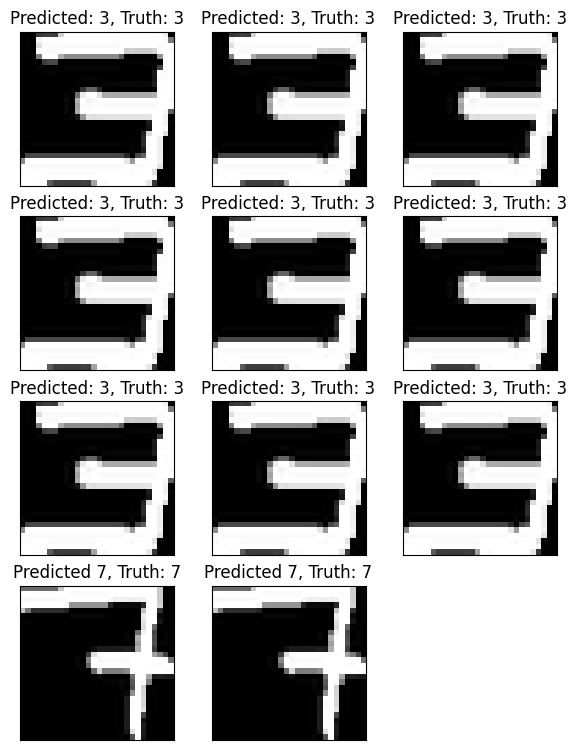

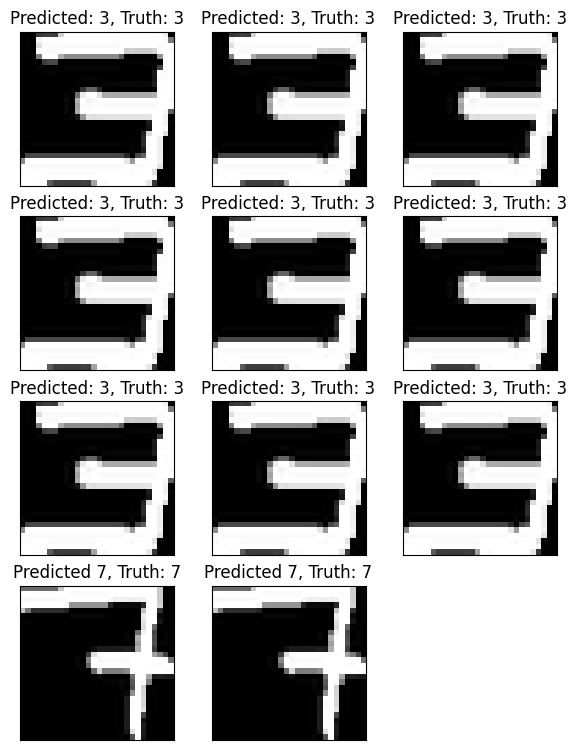

In [85]:
# load the model and create predictions on the test set
mnist_model = tf.keras.models.load_model("results/keras_mnist_base.h5")
# predict_x=model.predict(X_test) 
# classes_x=np.argmax(predict_x,axis=1)
predicted_classes = mnist_model.predict(test_set)

# see which we predicted correctly and which not
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]
print()
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")

# adapt figure size to accomodate 18 subplots
plt.rcParams['figure.figsize'] = (7,14)

figure_evaluation = plt.figure()

# plot 9 correct predictions
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(6,3,i+1)
    plt.imshow(x_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(
      "Predicted: {}, Truth: {}".format(test_label[correct],
                                        test_label[correct]))
    plt.xticks([])
    plt.yticks([])

# plot 9 incorrect predictions
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(6,3,i+10)
    plt.imshow(x_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(
      "Predicted {}, Truth: {}".format(test_label[incorrect], 
                                       test_label[incorrect]))
    plt.xticks([])
    plt.yticks([])

figure_evaluation

get weights and bias

In [92]:
for layer in model_base.layers:
    with open('results/config_layer_'+str(layer)+'.txt', 'a') as f:
        f.write(str(layer.get_config()))
for layer in model_base.layers:
    try :
        weights,bias=layer.get_weights()
        with open('results/weights_'+str(layer)+'.txt', 'a') as f:
            f.write(str(weights))
        with open('results/bias_'+str(layer)+'.txt', 'a') as f:
            f.write(str(bias))
    except:
        pass